# Model Evaluations and Predictions

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import accuracy_score
import cv2 as cv

In [31]:
import warnings
warnings.filterwarnings('ignore')

### Load Model

In [32]:
model = load_model('full_batch_model_v2.h5')

In [33]:
# Test dataset loading

test_img_gen = ImageDataGenerator(rescale=1./255)

Testing_Gen=test_img_gen.flow_from_directory('Eye_Images/Test', class_mode='binary', color_mode='grayscale', 
                                batch_size=32, target_size=(66,66), shuffle=False,seed=711)

Found 16979 images belonging to 2 classes.


In [34]:
train_img_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)


Training_Gen = train_img_gen.flow_from_directory('Eye_Images/Train', class_mode='binary', color_mode='grayscale', 
                                batch_size=32, target_size=(66,66), seed=711, 
                                subset='training')

Validation_Gen = train_img_gen.flow_from_directory('Eye_Images/Train', class_mode='binary', color_mode='grayscale', 
                                batch_size=32, target_size=(66,66), seed=711, 
                                subset='validation')

Found 50940 images belonging to 2 classes.
Found 16979 images belonging to 2 classes.


### Model Results

In [35]:
y_pred = np.round(model.predict(Testing_Gen))
y_true = Testing_Gen.labels
accuracy_score(y_true, y_pred)

0.9646033335296543

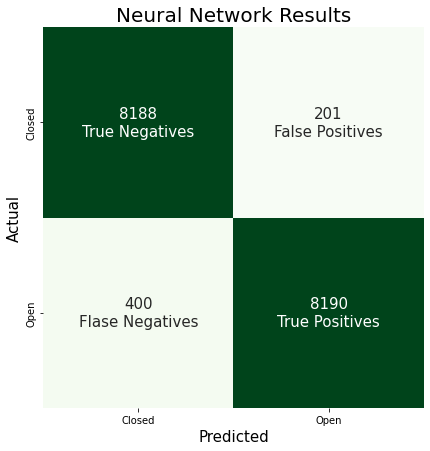

In [36]:
test_confusion = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
ax = sns.heatmap(test_confusion, cmap="Greens", annot=True, square=True,fmt='g',cbar=False,annot_kws={"size":15},
            xticklabels=['Closed', 'Open'], 
            yticklabels=['Closed', 'Open'])

cmlabels = ['True Negatives', "False Positives",
               'Flase Negatives', "True Positives"]
for i,t in enumerate(ax.texts):
  t.set_text(t.get_text() + "\n" + cmlabels[i])

plt.xlabel('Predicted', size=15)
plt.ylabel('Actual', size=15)
plt.title('Neural Network Results', size=20);
plt.savefig("NN_Confusion_Matrix.png")


#Open = 1
#Closed = 0

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8389
           1       0.98      0.95      0.96      8590

    accuracy                           0.96     16979
   macro avg       0.96      0.96      0.96     16979
weighted avg       0.96      0.96      0.96     16979



In [38]:
filenames = [x for x in Testing_Gen.filenames]
label = [x for x in y_true]
predict = [x[0] for x in y_pred]

import pandas as pd
df = pd.DataFrame(list(zip(filenames, label, predict)), columns=['Filenames', 'Label', 'Predict'])
df.head()

,Filenames,Label,Predict
0,Closed/s0001_00011_0_0_0_0_0_01.png,0,0.0
1,Closed/s0001_00012_0_0_0_0_0_01.png,0,0.0
2,Closed/s0001_00031_0_0_0_0_0_01.png,0,0.0
3,Closed/s0001_00034_0_0_0_0_0_01.png,0,0.0
4,Closed/s0001_00035_0_0_0_0_0_01.png,0,0.0


In [39]:
# function to add "Outcome" column
def predict_outcome(row):
    if (row['Label'] == 0) & (row['Predict'] == 0):
        return "TN"
    elif (row['Label'] == 0) & (row['Predict'] == 1):
        return "FP"
    elif (row['Label'] == 1) & (row['Predict'] == 1):
        return "TP"
    elif (row['Label'] == 1) & (row['Predict'] == 0):
        return "FN"

# applying function
df['Outcome'] = df.apply (lambda row: predict_outcome(row), axis=1)

In [40]:
def eye_state(path, model):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img_scale = img/255 
    img_scale = np.expand_dims(img_scale.reshape(66,66,1),axis=0)

    
    prediction = np.round(model.predict(img_scale))[0][0]   
    labels = {0:'Closed', 1:'Open'}
    prediction = labels[prediction]
    
    print(f'Eye is predicted to be {prediction}, but is miss labeled')
    plt.imshow(img,cmap='gray')

In [41]:
df.Outcome.value_counts()

TP    8190
TN    8188
FN     400
FP     201
Name: Outcome, dtype: int64

### False Positive Analysis

In [42]:
df[df["Outcome"]=="FP"]

,Filenames,Label,Predict,Outcome
28,Closed/s0001_00165_0_0_0_0_0_01.png,0,1.0,FP
29,Closed/s0001_00166_0_0_0_0_0_01.png,0,1.0,FP
31,Closed/s0001_00176_0_0_0_0_0_01.png,0,1.0,FP
180,Closed/s0001_00863_0_0_0_0_0_01.png,0,1.0,FP
194,Closed/s0001_00927_0_1_0_2_0_01.png,0,1.0,FP
...,...,...,...,...
7279,Closed/s0037_00552_1_0_0_0_1_01.png,0,1.0,FP
7290,Closed/s0037_00602_1_0_0_0_1_01.png,0,1.0,FP
7291,Closed/s0037_00604_1_0_0_0_0_01.png,0,1.0,FP
7345,Closed/s0037_00850_1_0_0_0_0_01.png,0,1.0,FP


Eye is predicted to be Open, but is miss labeled


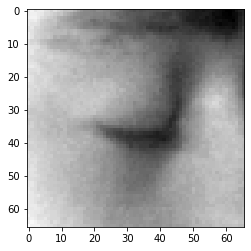

In [43]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FP"].iloc[0,0]
eye_state(path,model)

Eye is predicted to be Open, but is miss labeled


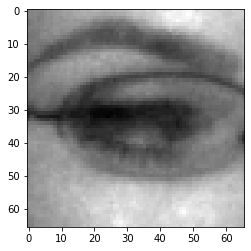

In [58]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FP"].iloc[200,0]
eye_state(path,model)

Eye is predicted to be Open, but is miss labeled


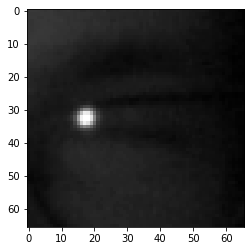

In [45]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FP"].iloc[55,0]
eye_state(path,model)

Eye is predicted to be Open, but is miss labeled


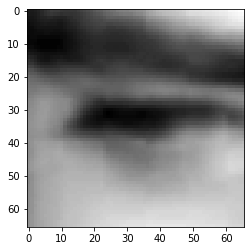

In [57]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FP"].iloc[99,0]
eye_state(path,model)

### False Negative Analysis

In [47]:
df[df["Outcome"]=="FN"]

,Filenames,Label,Predict,Outcome
8398,Open/s0001_01895_0_0_1_0_0_01.png,1,0.0,FN
8403,Open/s0001_01918_0_0_1_0_0_01.png,1,0.0,FN
8412,Open/s0001_01948_0_0_1_0_0_01.png,1,0.0,FN
8415,Open/s0001_01960_0_0_1_0_0_01.png,1,0.0,FN
8416,Open/s0001_01962_0_0_1_0_0_01.png,1,0.0,FN
...,...,...,...,...
16834,Open/s0037_09540_1_1_1_2_0_01.png,1,0.0,FN
16892,Open/s0037_09902_1_1_1_2_1_01.png,1,0.0,FN
16896,Open/s0037_09925_1_1_1_2_0_01.png,1,0.0,FN
16934,Open/s0037_10111_1_1_1_2_1_01.png,1,0.0,FN


Eye is predicted to be Closed, but is miss labeled


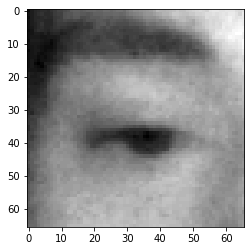

In [48]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FN"].iloc[0,0]
eye_state(path,model)

Eye is predicted to be Closed, but is miss labeled


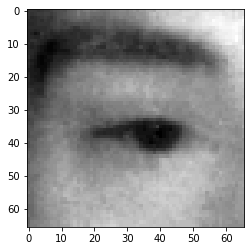

In [52]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FN"].iloc[30,0]
eye_state(path,model)

Eye is predicted to be Closed, but is miss labeled


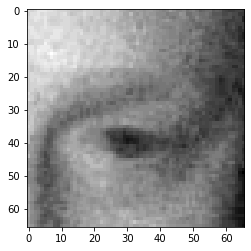

In [53]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FN"].iloc[50,0]
eye_state(path,model)

Eye is predicted to be Closed, but is miss labeled


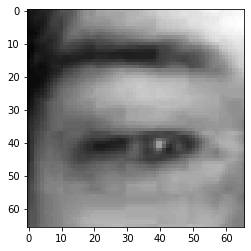

In [56]:
path = 'Eye_Images/Test/'+df[df["Outcome"]=="FN"].iloc[349,0]
eye_state(path,model)